<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Нужно построить модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import numpy as np

import itertools

import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/ynd/on GitHub/Churn_Modelling.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1, inplace=True)

One-hot encoding

In [ ]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [ ]:
df_ohe.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0


Проверка на пропуски показала, что значение Tenure, сколько человек в банке в годах, имеет 909 пропусков.

In [ ]:
df_ohe.isna().sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64

Сложно предположить причину этих пропусков. Поэтому я заменю пропущенные значения заглушкой "0".

In [ ]:
df_ohe[df_ohe['Tenure'].isna()].head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male


In [ ]:
df_ohe['Tenure'] = df_ohe['Tenure'].fillna(0)

In [ ]:
df_ohe['Tenure'].isna().sum()

0

**Вывод:**

* удалил неинформативные столбцы — Surname, RowNumber, Geography;
* выполнил горячее кодирование категориальных признаков;
* заменил пропущенные значения в столбце Tenure на заглушку.

## Исследование задачи

Разделю датасет на 3 части — train, valid и test.

In [ ]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.20, frac_test=0.20,
                                         random_state=None):
    '''
    Функция разбивает датасет на три подмножества (train, val и test),
    где каждое подмножество стратифицировано по значениям в определенном столбце(target).

    Параметры:
    ----------
    df_input — датасет, который будем делить.
    stratify_colname — название столбца, который будет использоваться для стратификации.
    frac_train, frac_val и frac_test — соотношения, с которыми датасет
    будет разделен на train, val и test.
    random_state — значение, которое будет передано в train_test_split().

    Возвращается:
    -------
    df_train, df_val, df_test — необходимые выборки.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # features
    y = df_input[[stratify_colname]] # target

    # датасет будет разделен в два этапа
    df_train, df_temp, y_train, y_temp = (
        train_test_split(
        X,
        y,
        stratify=y,
        test_size=(1.0 - frac_train),
        random_state=random_state
        )
    )

    relative_frac_test = frac_test / (frac_val + frac_test)

    df_val, df_test, y_val, y_test = (
        train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state
        )
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

Таким образом получаю соотношения 3:1:1

In [ ]:
df_train, df_val, df_test = (
    split_stratified_into_train_val_test(
        df_ohe,
        stratify_colname='Exited',
        frac_train=.60, frac_val=.20, frac_test=.20,
        random_state=666
    )
)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(6000, 12)
(2000, 12)
(2000, 12)


Теперь разделю каждую выборку на признаки.

In [ ]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_valid = df_val.drop(['Exited'], axis=1)
target_valid = df_val['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

Столбцы с численными значениями имеют разный диапазон значений. Проведу масштабирование признаков.

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance',
           'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Логистическая регрессия

In [ ]:
lr = LogisticRegression(random_state=666, solver='liblinear')
lr.fit(features_train, target_train)
predictions_lr = lr.predict(features_valid)

probabilities_valid = lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Воспользуюсь функцией построения матрицы ошибок из документации sklearn

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1530   62]
 [ 315   93]]


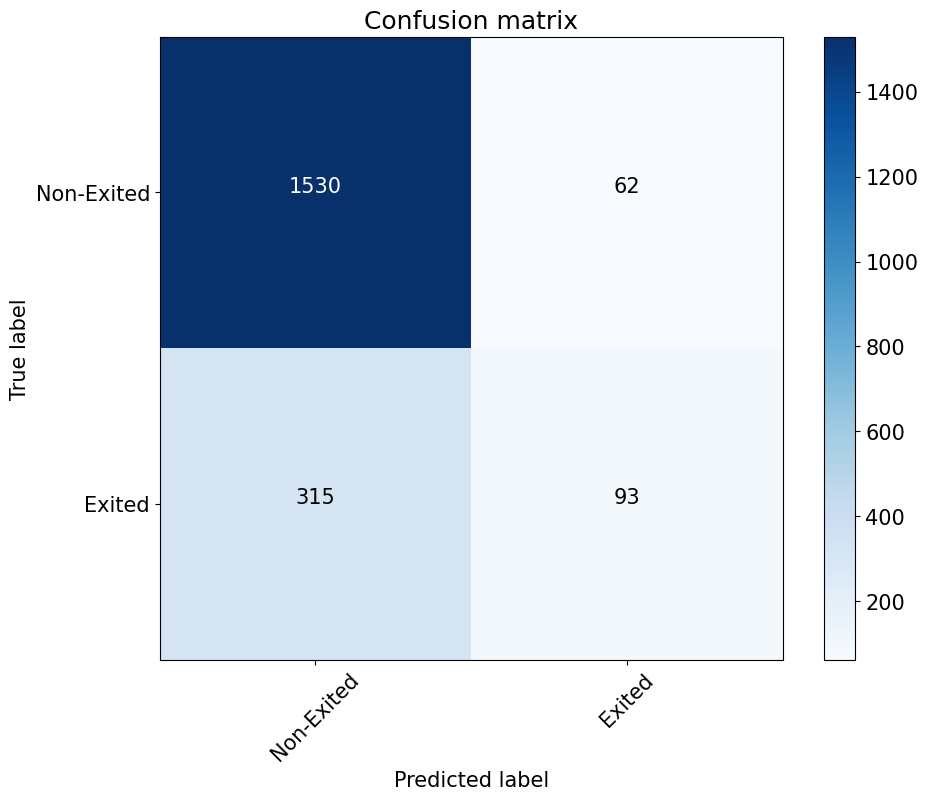

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(target_valid, predictions_lr)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Метрики с базовыми гиперпараметрами:

In [ ]:
print("Recall:", recall_score(target_valid, predictions_lr))
print("Precision:", precision_score(target_valid, predictions_lr))
print("F1:", f1_score(target_valid, predictions_lr))
print("ROC_auc:", roc_auc_score(target_valid, probabilities_one_valid))

Recall: 0.22794117647058823
Precision: 0.6
F1: 0.33037300177619894
ROC_auc: 0.7452673908759483


Подберу оптимальный порог для классификации:

In [ ]:
probabilities_valid = lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.62, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid)))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.02 | Точность = 0.205, Полнота = 1.000, F1 = 0.340
Порог = 0.04 | Точность = 0.215, Полнота = 0.988, F1 = 0.353
Порог = 0.06 | Точность = 0.232, Полнота = 0.971, F1 = 0.374
Порог = 0.08 | Точность = 0.245, Полнота = 0.931, F1 = 0.388
Порог = 0.10 | Точность = 0.259, Полнота = 0.890, F1 = 0.402
Порог = 0.12 | Точность = 0.276, Полнота = 0.850, F1 = 0.417
Порог = 0.14 | Точность = 0.300, Полнота = 0.816, F1 = 0.439
Порог = 0.16 | Точность = 0.323, Полнота = 0.784, F1 = 0.457
Порог = 0.18 | Точность = 0.330, Полнота = 0.733, F1 = 0.455
Порог = 0.20 | Точность = 0.341, Полнота = 0.674, F1 = 0.453
Порог = 0.22 | Точность = 0.365, Полнота = 0.630, F1 = 0.462
Порог = 0.24 | Точность = 0.386, Полнота = 0.596, F1 = 0.469
Порог = 0.26 | Точность = 0.400, Полнота = 0.551, F1 = 0.464
Порог = 0.28 | Точность = 0.418, Полнота = 0.520, F1 = 0.463
Порог = 0.30 | Точность = 0.436, Полнота = 0.480, F1 = 0.457
Порог = 0.32 | Точность 

Случайный лес

Подберу оптимальные гиперпараметры:

In [ ]:
parameters = {
    'n_estimators' : [25,50,100,150],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20]
}

rfc = RandomForestClassifier(random_state=666)

clf_rfc = GridSearchCV(
    estimator = rfc,
    param_grid = parameters,
    scoring = 'f1',
    cv=5)

clf_rfc.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=666),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='f1')

In [ ]:
model_base_rfc = clf_rfc.best_estimator_.fit(features_train, target_train)
predictions_rfc = model_base_rfc.predict(features_valid)

probabilities_valid = model_base_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Confusion matrix, without normalization
[[1530   62]
 [ 229  179]]


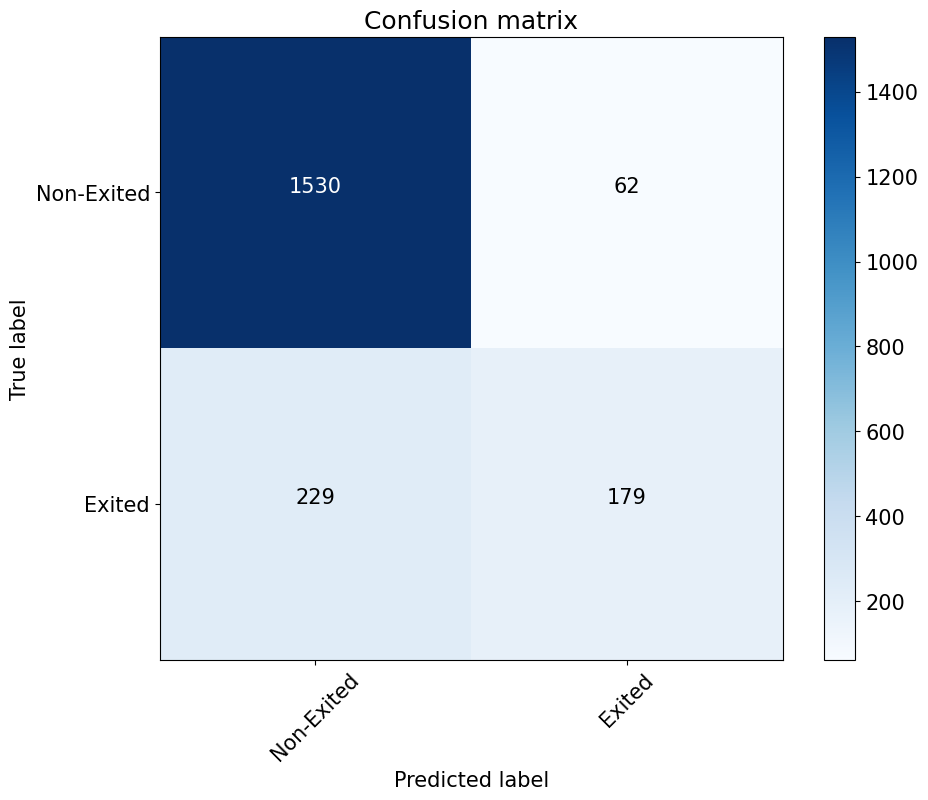

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(target_valid, predictions_rfc)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Exited', 'Exited'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
print("Recall:", recall_score(target_valid, predictions_rfc))
print("Precision:", precision_score(target_valid, predictions_rfc))
print("F1:", f1_score(target_valid, predictions_rfc))
print("ROC_auc:", roc_auc_score(target_valid, probabilities_one_valid))

Recall: 0.4387254901960784
Precision: 0.7427385892116183
F1: 0.551617873651772
ROC_auc: 0.853094362745098


**Вывод:**

Базовая модель логистической регрессии на валидационной выборке показала результат по f1 и roc_auc 0.25 и 0.72.
При изменении порога классификации в логистической регрессии оптимальные значений метрик составляют Порог = 0.26 | Точность = 0.385, Полнота = 0.537, F1 = 0.448, ROC_auc = 0.72

Модель случайного леса на тестовых данных f1 и roc_auc соответственно 0.5 и 0.83.

Из-за несбалансированности данных у моделей полнота ниже, чем точность, это влияет на F-меру. У модели случайного леса метрики лучше, чем у логистической регрессии.

## Борьба с дисбалансом

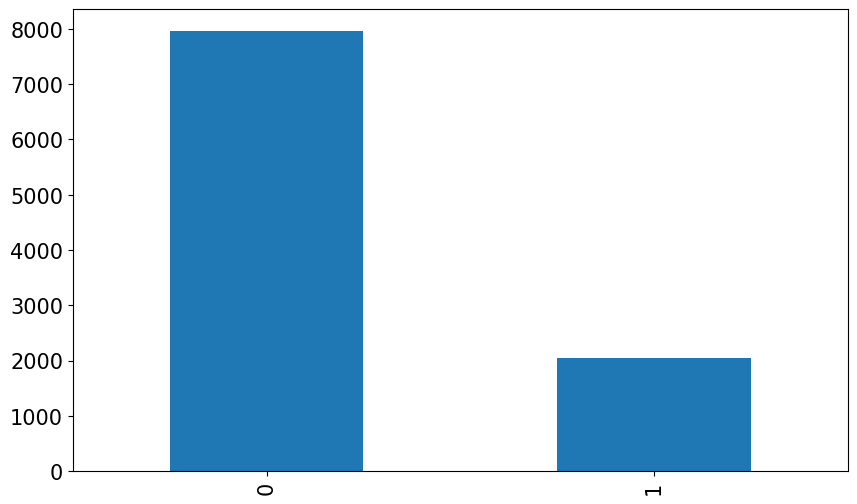

In [ ]:
df_ohe['Exited'].value_counts().plot(kind='bar',
                                     figsize=(10, 6))
plt.show()

Исследуемая метрика — отток клиентов, Exited. На графике виден дисбаланс классов.

Снова обучу логистическую регрессию, но установлю параметр баланса классов:

In [ ]:
model = LogisticRegression(random_state=666, solver='liblinear',class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid, predicted_valid))
print("ROC_auc:", roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.47160068846815845
ROC_auc: 0.7508082692876146


Рассчитаю оптимальный порог:

In [ ]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.62, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f} | F1 = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid)))

Порог = 0.00 | Точность = 0.204 | Полнота = 1.000 | F1 = 0.339
Порог = 0.02 | Точность = 0.204 | Полнота = 1.000 | F1 = 0.339
Порог = 0.04 | Точность = 0.204 | Полнота = 1.000 | F1 = 0.339
Порог = 0.06 | Точность = 0.205 | Полнота = 1.000 | F1 = 0.340
Порог = 0.08 | Точность = 0.206 | Полнота = 1.000 | F1 = 0.341
Порог = 0.10 | Точность = 0.209 | Полнота = 0.995 | F1 = 0.345
Порог = 0.12 | Точность = 0.212 | Полнота = 0.995 | F1 = 0.350
Порог = 0.14 | Точность = 0.215 | Полнота = 0.988 | F1 = 0.354
Порог = 0.16 | Точность = 0.222 | Полнота = 0.978 | F1 = 0.362
Порог = 0.18 | Точность = 0.227 | Полнота = 0.978 | F1 = 0.369
Порог = 0.20 | Точность = 0.231 | Полнота = 0.963 | F1 = 0.373
Порог = 0.22 | Точность = 0.236 | Полнота = 0.949 | F1 = 0.377
Порог = 0.24 | Точность = 0.243 | Полнота = 0.941 | F1 = 0.386
Порог = 0.26 | Точность = 0.249 | Полнота = 0.929 | F1 = 0.392
Порог = 0.28 | Точность = 0.255 | Полнота = 0.909 | F1 = 0.398
Порог = 0.30 | Точность = 0.259 | Полнота = 0.890 | F1 

Посмотрим, как изменилась матрица после балансировки классов:

Confusion matrix, without normalization
[[1300  292]
 [ 194  214]]


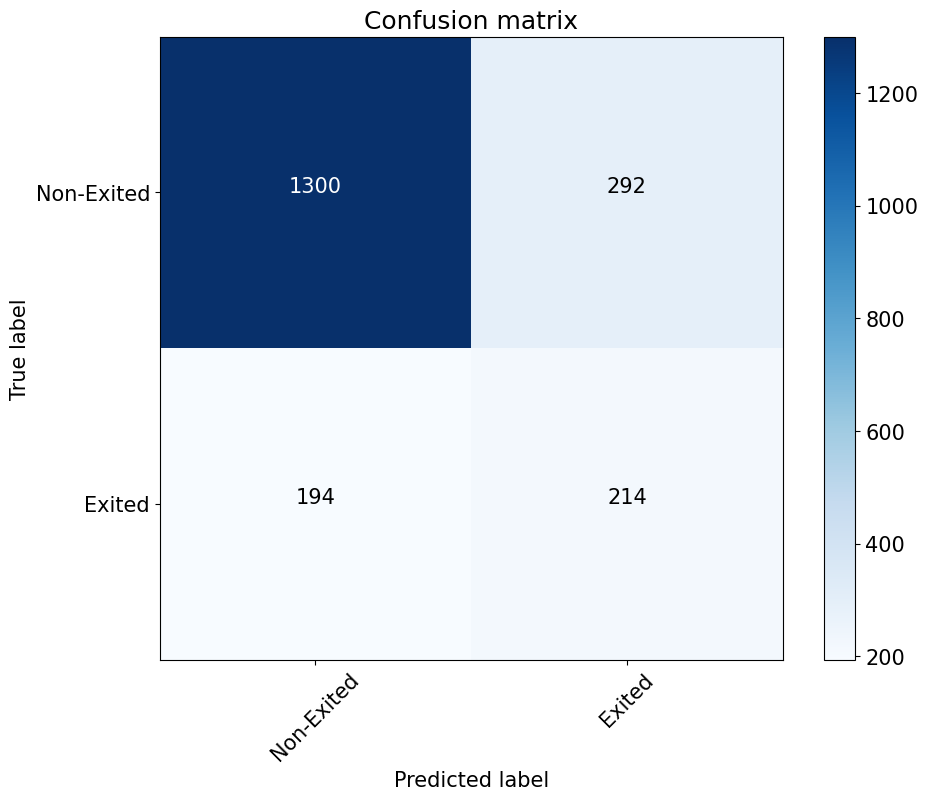

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(target_valid, predicted_valid)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

Обучу модель случайного леса с лучшими параметрами и балансом классов:

In [ ]:
parameters = {
    'n_estimators' : [25,50,100,150],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20],
    'class_weight' : ['balanced']
}

rfc = RandomForestClassifier(random_state=666)

rfc_balanced = GridSearchCV(
    estimator = rfc,
    param_grid = parameters,
    scoring = 'f1',
    cv=5)

rfc_balanced.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=666),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='f1')

In [ ]:
model_rfc_balanced = rfc_balanced.best_estimator_.fit(features_train, target_train)
predicted_valid = model_rfc_balanced.predict(features_valid)

probabilities_valid = model_rfc_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1:", f1_score(target_valid, predicted_valid))
print("ROC_auc:", roc_auc_score(target_valid, probabilities_one_valid))

F1: 0.6017052375152254
ROC_auc: 0.8592733890038426


Рассчитаю оптимальный порог:

In [ ]:
probabilities_valid = model_rfc_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f} | F1 = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid)))

Порог = 0.00 | Точность = 0.204 | Полнота = 1.000 | F1 = 0.339
Порог = 0.02 | Точность = 0.204 | Полнота = 1.000 | F1 = 0.339
Порог = 0.04 | Точность = 0.209 | Полнота = 1.000 | F1 = 0.346
Порог = 0.06 | Точность = 0.218 | Полнота = 0.998 | F1 = 0.358
Порог = 0.08 | Точность = 0.231 | Полнота = 0.995 | F1 = 0.375
Порог = 0.10 | Точность = 0.244 | Полнота = 0.990 | F1 = 0.392
Порог = 0.12 | Точность = 0.258 | Полнота = 0.988 | F1 = 0.410
Порог = 0.14 | Точность = 0.272 | Полнота = 0.985 | F1 = 0.426
Порог = 0.16 | Точность = 0.284 | Полнота = 0.971 | F1 = 0.439
Порог = 0.18 | Точность = 0.296 | Полнота = 0.953 | F1 = 0.452
Порог = 0.20 | Точность = 0.317 | Полнота = 0.941 | F1 = 0.474
Порог = 0.22 | Точность = 0.332 | Полнота = 0.909 | F1 = 0.487
Порог = 0.24 | Точность = 0.352 | Полнота = 0.892 | F1 = 0.505
Порог = 0.26 | Точность = 0.368 | Полнота = 0.875 | F1 = 0.518
Порог = 0.28 | Точность = 0.385 | Полнота = 0.860 | F1 = 0.532
Порог = 0.30 | Точность = 0.404 | Полнота = 0.848 | F1 

После балансировки классов метрики на обоих моделях улучшили результаты.

Для логистической регресии — Порог = 0.52 | Точность = 0.360 | Полнота = 0.635 | F1 = 0.459 | ROC_auc = 0.730

Для случайного леса — Порог = 0.42 | Точность = 0.500 | Полнота = 0.676 | F1 = 0.575 | ROC_auc = 0.838

Upsampling

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

probabilities_valid_lr = lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

probabilities_valid_rfc = model_base_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

lr.fit(features_upsampled, target_upsampled)
predicted_valid_lr = lr.predict(features_valid)
rfc.fit(features_upsampled, target_upsampled)
predicted_valid_rfc = rfc.predict(features_valid)

print(target_upsampled.value_counts())
print("F1 для логистической регрессии:", f1_score(target_valid, predicted_valid_lr))
print("Roc auc для логистической регрессии:", roc_auc_score(target_valid, probabilities_one_valid_lr))
print("F1 для случайного леса:", f1_score(target_valid, predicted_valid_rfc))
print("Roc auc для случайного леса:", roc_auc_score(target_valid, probabilities_one_valid_rfc))

1    4888
0    4778
Name: Exited, dtype: int64
F1 для логистической регрессии: 0.4723874256584537
Roc auc для логистической регрессии: 0.7452673908759483
F1 для случайного леса: 0.592087312414734
Roc auc для случайного леса: 0.853094362745098


Downsampling

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = shuffle(pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]), random_state=12345)
    target_downsampled = shuffle(pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]), random_state=12345)

    return features_downsampled, target_downsampled

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

probabilities_valid_lr = lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

probabilities_valid_rfc = model_base_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]


lr.fit(features_downsampled, target_downsampled)
predicted_valid_lr = lr.predict(features_valid)
rfc.fit(features_downsampled, target_downsampled)
predicted_valid_rfc = rfc.predict(features_valid)

print(target_downsampled.value_counts())
print("F1 для логистической регрессии:", f1_score(target_valid, predicted_valid_lr))
print("Roc auc для логистической регрессии:", roc_auc_score(target_valid, probabilities_one_valid_lr))
print("F1 для случайного леса:", f1_score(target_valid, predicted_valid_rfc))
print("Roc auc для случайного леса:", roc_auc_score(target_valid, probabilities_one_valid_rfc))

1    1222
0    1194
Name: Exited, dtype: int64
F1 для логистической регрессии: 0.4708904109589041
Roc auc для логистической регрессии: 0.7509021824810326
F1 для случайного леса: 0.5847953216374269
Roc auc для случайного леса: 0.853094362745098


Наилучшего баланса классов при увеличения выборки удалось получить с repeat = 4:

* F1 для логистической регрессии: 0.4351851851851851
* Roc auc для логистической регрессии: 0.6434978199822643
* F1 для случайного леса: 0.5922865013774106
* Roc auc для случайного леса: 0.8525616747955463

Наилучшего баланса классов при уменьшении выборки удалось получить с fraction = 0.3:

* F1 для логистической регрессии: 0.4609595484477893
* Roc auc для логистической регрессии: 0.6714762538181103
* F1 для случайного леса: 0.5443037974683543
* Roc auc для случайного леса: 0.7276086313922554

Увеличение выборки при дисбалансе классов дало лучшие результаты, чем уменьшение. Но эти метрики значительно уступают, если устанавливать параметр баланс классов и не проводить манипуляции с выборками.

# Tensor Flow

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(11,), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
sample_weights = np.ones(len(target_train))
sample_weights[target_train == 1] = class_weights[1]

model.fit(features_train, target_train, epochs=100, sample_weight=sample_weights)

Epoch 1/100
188/188 [==============================] - 2s 4ms/step - loss: 0.9473 - accuracy: 0.6812
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.7863 - accuracy: 0.7503
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.7457 - accuracy: 0.7743
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.7281 - accuracy: 0.7798
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 0.7194 - accuracy: 0.7827
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.7965
Epoch 7/100
188/188 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.7963
Epoch 8/100
188/188 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.7992
Epoch 9/100
188/188 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.8020
Epoch 10/100
188/188 [==============================] - 0s 2ms/step - loss: 0.6800 - accura

In [ ]:
tf_predict = model.predict(features_valid)
y_pred_binary = np.round(tf_predict)

63/63 [==============================] - 0s 1ms/step


In [ ]:
print("F1 для полносвязной нейросети:", f1_score(target_valid, y_pred_binary))
print("Roc auc для полносвязной нейросети:", roc_auc_score(target_valid, y_pred_binary))

F1 для полносвязной нейросети: 0.5333333333333333
Roc auc для полносвязной нейросети: 0.7178662922455413


## Тестирование модели

Лучше всего себя показала полносвязная нейросеть с балансировкой классов. Проверю ее на тестовой выборке.

In [ ]:
probabilities_test = model.predict(features_test)
probabilities_one_test = probabilities_test.flatten()

threshold = 0.42

predicted_test = (probabilities_one_test > threshold).astype(int)

precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)

print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f} | F1 = {:.3f} | Accuracy = {:.3f}".format(
    threshold, precision, recall, f1, accuracy))

63/63 [==============================] - 0s 2ms/step
Порог = 0.42 | Точность = 0.450 | Полнота = 0.614 | F1 = 0.520 | Accuracy = 0.769


In [ ]:
print("Roc auc = ", roc_auc_score(target_test, probabilities_one_test))

Roc auc =  0.8013252081048691


Модель на тестовой выборке показала результаты:

Порог = 0.42 | Точность = 0.417 | Полнота = 0.794 | F1 = 0.547 | Accuracy = 0.733

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

<Figure size 640x480 with 0 Axes>

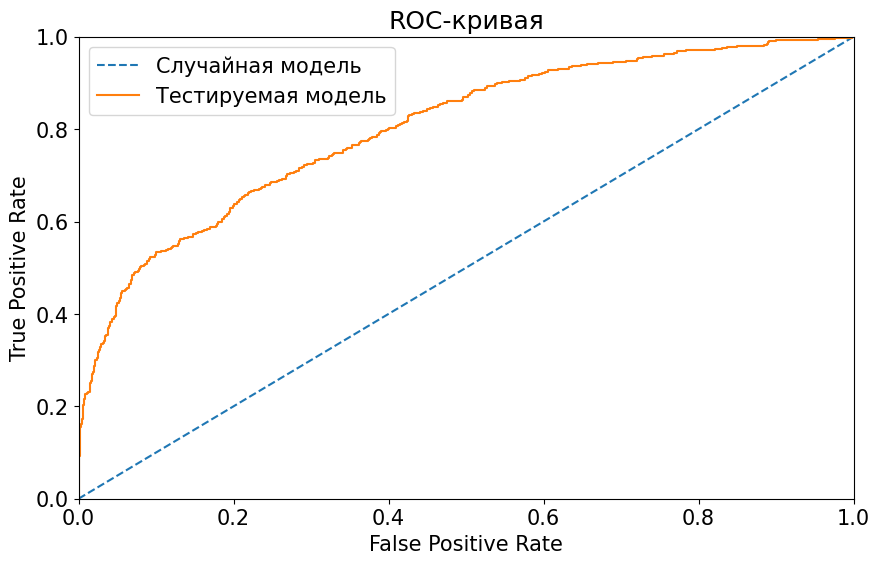

In [ ]:
plt.figure()

plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Тестируемая модель'),
           loc= 'upper left')
plt.show()

**Вывод:**
* модели со сбалансированными классами дали лучшие результаты, чем увеличение и уменьшение выборок
* Порог = 0.42 | Точность = 0.450 | Полнота = 0.614 | F1 = 0.520 | Accuracy = 0.769
